In [ ]:
#@ INSTALLING THE LIBRARIES AND MODULES
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
#@ LOADING THE DATASET
import os
data = pd.read_csv("/content/drive/MyDrive/Natual Language Processing in Action/dataset/in_domain_train.tsv",
                   delimiter='\t',
                   header=None,
                   names=['sentence_source', 'label', 'label_notes', 'sentence'])

print(f'The shape of the data is: {data.shape}')

The shape of the data is: (8551, 4)


In [ ]:
data.sample(10)

,sentence_source,label,label_notes,sentence
6076,c_13,1,NaN,calvin will be eating .
3439,ks08,1,NaN,the tall man kicked the ball .
913,bc01,0,?*,"i know which book mag read , and which book bo..."
5651,c_13,1,NaN,the assassination of the president .
6135,c_13,0,*,the bed was fallen on by the dust .
2918,l-93,1,NaN,smith was annealing .
3160,l-93,0,*,my eyes are itching my brother .
337,bc01,1,NaN,he can not have been working .
4133,ks08,1,NaN,no john smiths attended the meeting .
5724,c_13,1,NaN,that dan smokes in the office really bothers a...


In [ ]:
#@ CREATING SENTENCES, LABEL LISTS, AND ADDING BERT TOKENS
sentences = data.sentence.values
sentences = ["[CLS] " + sentence + "[SEP] " for sentence in sentences]
labels = data.label.values

In [ ]:
#@ ACTIVAING THE BERT TOKENIZER
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lowercase=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence: ")
print(tokenized_texts[1])

Tokenize the first sentence: 
['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'and', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]']


In [ ]:
#@ PROCESSING THE DATA
MAX_LEN = 128                                                                                                     # Setting up maximum length of data
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]                                         # Convert tokens to index numbers
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')             # Padding the input tokens

In [ ]:
#@ CREATING ATTENTION MASKS
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
#@ SPLITTING THE DATA INTO TRAINING AND VALIDATION SETS
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)

In [ ]:
#@ CONVERTING ALL DATA INTO TORCH TENSORS
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
#@ SELECTING BATCH SIZE AND CREATING ITERATOR
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



In [ ]:
#@ BERT MODEL CONFIGURATION
import transformers
from transformers import BertModel, BertConfig
configuration = BertConfig()
model = BertModel(configuration)                                      # Initialize model from BERT base uncased style
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@ LOADING THE HUGGING FACE BERT UNCASED BASE MODEL
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = nn.DataParallel(model)
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [ ]:
#@ OPTIIMIZER GROUPED PARAMETERS
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
#@ HYPERPARAMETERS FOR THE TRAINING LOOP
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5,
                  eps = 1e-8
                  )

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#@ CREATING ACCURACY MEASUREMENT FUNCTIONS
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat==labels_flat) / len(labels_flat)

In [ ]:
#@ THE TRAINING LOOP
t = []
train_loss_set = []                                                       # Store our loss and accuracy for plotting

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  model.train()                                                            # Set our model to training mode (as opposed to evaluation mode)
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)                            # Add batch to GPU
    b_input_ids, b_input_mask, b_labels = batch                           # Unpack the inputs from our dataloader
    optimizer.zero_grad()                                                 # Clear out the gradients (by default they accumulate)
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)          # Forward pass
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    loss.backward()                                                         # Backward pass
    optimizer.step()                                                        # Update parameters and take a step using the computed gradient
    scheduler.step()                                                        # Update the learning rate

    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)                                               # Add batch to GPU
    b_input_ids, b_input_mask, b_labels = batch                                              # Unpack the inputs from our dataloader
    # Telling model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5127052732770374


Epoch:  25%|██▌       | 1/4 [02:28<07:25, 148.56s/it]

Validation Accuracy: 0.7797067901234568
Train loss: 0.30965869750101044


Epoch:  50%|█████     | 2/4 [05:04<05:05, 152.93s/it]

Validation Accuracy: 0.8233024691358025
Train loss: 0.19087278550776704


Epoch:  75%|███████▌  | 3/4 [07:41<02:34, 154.62s/it]

Validation Accuracy: 0.8263888888888888
Train loss: 0.12596570025681214


Epoch: 100%|██████████| 4/4 [10:18<00:00, 154.63s/it]

Validation Accuracy: 0.8321759259259259


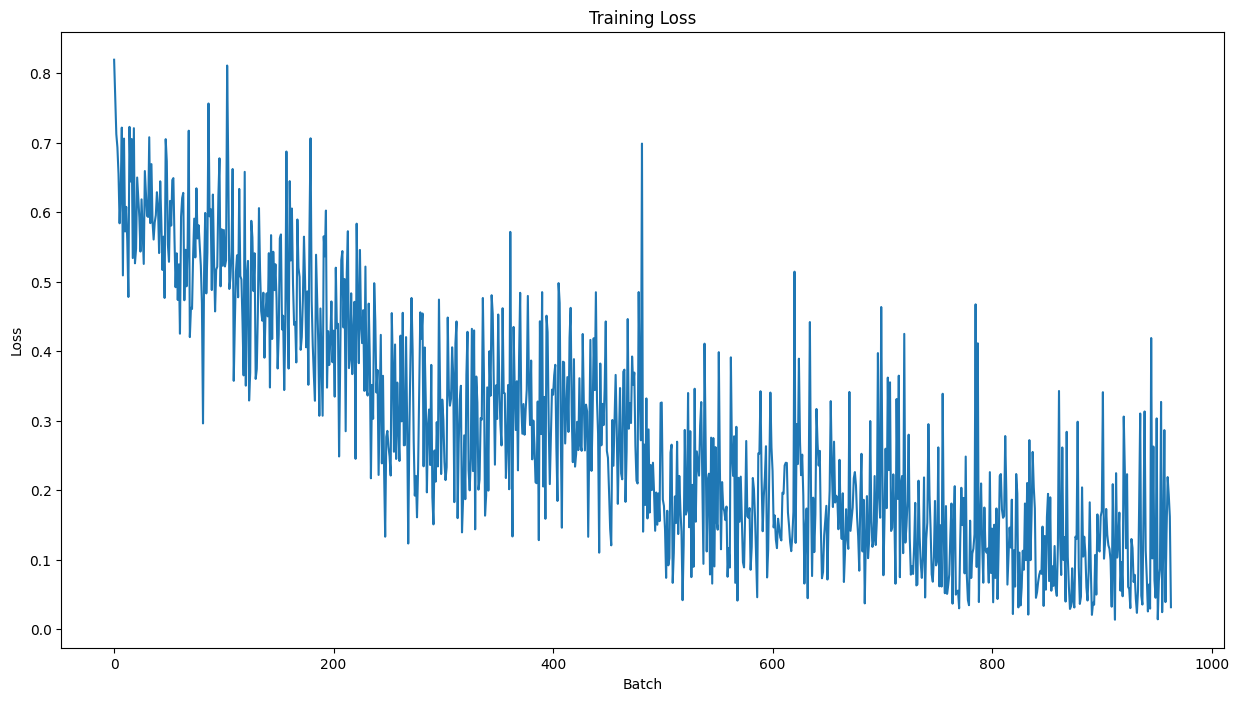

In [ ]:
#@ TRAINING EVALUATION
plt.figure(figsize=(15,8))
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
#@ PREDICTING AND EVALUATING USING THE HOUSEHOLD DATASET
df = pd.read_csv("/content/drive/MyDrive/Natual Language Processing in Action/dataset/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)



In [ ]:
#@ PREDICTION ON TEST SET
model.eval()                                # Put model in evaluation mode

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
#@ EVALUATING USING THE MATTHEWS CORRELATION COEFFICIENT
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                               np.argmax(predictions[i], axis=1).flatten()
                               )
  matthews_set.append(matthews)

In [ ]:
matthews_set

[0.049286405809014416,
 -0.21684543705982773,
 0.4040950971038548,
 0.30508307783296046,
 0.4133804997216296,
 0.6777932975034471,
 0.4472135954999579,
 0.47519096331149147,
 0.9165151389911681,
 0.8246211251235321,
 0.8454106280193237,
 0.6666666666666666,
 0.8150678894028793,
 0.7141684885491869,
 0.1794871794871795,
 0.5716350506349809,
 0.0]

In [ ]:
#@ MATTHEWS EVALUATION FOR WHOLE DATASET
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.534936021898104